<a href="https://colab.research.google.com/github/SamuelXJames/Signal-Denoising-Autoencoder/blob/master/LSTM_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Traceback (most recent call last):

Wait for 8 seconds...
TensorBoard link:
https://d5508a8a.ngrok.io
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 200, 1)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 300)               362400    
_________________________________________________________________
repeat_vector_12 (RepeatVect (None, 200, 300)          0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 200, 300)          721200    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 200, 1)            301       
Total params: 1,083,901
Trainable params: 1,083,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
100/100 [=========

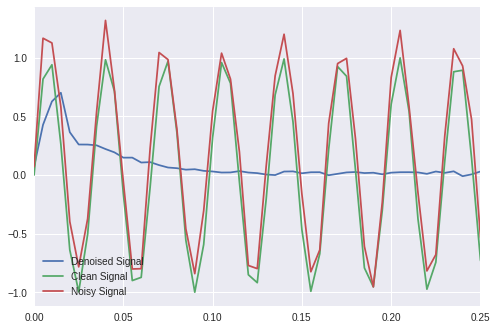

In [12]:
#Additional Packages to Install
# !pip install pydrive
# !pip install git+https://github.com/hyperopt/hyperopt.
# !pip install kopt
# !pip install oauth2client
# !pip install tensorboardcolab

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorboardcolab import *
import pydrive
from keras.layers import Input
from keras.layers import LSTM, RepeatVector, TimeDistributed
from keras.layers import Activation, BatchNormalization
from keras.models import Model,Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from kopt import CompileFN, KMongoTrials, test_fn
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


#Authenticate/Create PyDrive client 
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)




tbc=TensorBoardColab()
batch_size = 100


def create_data():
  length = 1
  dt = 0.005
  noise_factor = 0.35
  data = []
  data_noisy = []
  for i in range(batch_size):
      freq = 30*np.random.random() + 1
      t = np.arange(0,length,dt)
      #signal = np.arange(-0.5*length,0.5*length,dt)
      signal = np.sin(2*np.pi*freq*t)
      noisy_signal = signal+noise_factor*np.random.rand(len(t))
      data.append(signal)
      data_noisy.append(noisy_signal)
  data = np.array(data)
  data_noisy = np.array(data_noisy)
  return t,data, data_noisy
#Create Test/Train Data
t,signal,signal_noisy = create_data()

#Scale Data - Need a better scaler than MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
data  = np.vstack((signal,signal_noisy))
data = scaler.fit_transform(data)
signal = data[0:batch_size][:]
signal_noisy = data[batch_size:2*batch_size][:]



#Prediction Data
x_pred = signal_noisy[0][:]
#Pre Autoencoder
x_pred_pre = signal_noisy[0] 
x_pred_pre = x_pred_pre.reshape((-1,len(x_pred_pre)))
x_pred_pre = scaler.inverse_transform(x_pred_pre)
#Clean
clean_signal = signal[0][:]
clean_signal = clean_signal.reshape((-1,len(clean_signal)))
clean_signal = scaler.inverse_transform(clean_signal)

#Input Shaping
features = 1
timesteps = len(signal[0])
z_timesteps = timesteps-1
shape = (batch_size,timesteps,features)
#Input shape should equal [samples, timesteps, features]
x = signal.reshape(shape)
y = signal_noisy.reshape(shape)
z = y[:,1:,:]
#x_pred = x_pred.reshape(1,timesteps,features)


#A custom loss function may work better than some 
#of the loss functionss provided by Keras
#Here is a loss function from Hvass Labs that
#invokes a warmup period
warmup_steps = 10
def loss_mse_warmup(y_true, y_pred):
    

    
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean


#NOT THE OPTIMIZED MODEL
def create_LSTM():
  inputs = Input(shape = (timesteps,features))
  
  encoded =  LSTM(300,activation = 'relu')(inputs)
  
  decoded = RepeatVector(timesteps)(encoded)
  decoded = LSTM(300,activation = 'relu', return_sequences = True)(decoded)
  decoded = TimeDistributed(Dense(1))(decoded)
  
  
  
  decoded_2 = RepeatVector(z_timesteps)(encoded)
  decoded_2 = LSTM(50,activation = 'relu', return_sequences = True)(decoded_2)
  decoded_2 = TimeDistributed(Dense(1))(decoded_2)
  
  
  
  encoder_decoder = Model(inputs,[decoded,decoded_2])
  autoencoder = Model(inputs,decoded)
  
  
  
  
  return autoencoder





def nn_predict(model,prediction_data):
  pad_length = timesteps-(np.size(prediction_data)%timesteps)
  if pad_length != timesteps:
    prediction_data = np.pad(prediction_data,[(0,0),(0,pad_length)],
                             mode = 'constant', constant_values = 0)
   
  prediction_data = prediction_data.reshape((-1,timesteps))
  
  predicted_data = []
  
  for i in range(np.size(prediction_data,0)):
    pred_part = prediction_data[i].reshape(1,timesteps,features) 
    pred_part = model.predict(pred_part)
    predicted_data.append(pred_part)
  
  predicted_data = (np.array(predicted_data)).flatten()
  
  predicted_data = predicted_data.reshape(-1,len(predicted_data))
  predicted_data = scaler.inverse_transform(predicted_data)
  return predicted_data



#NN HyperParameters
epochs = 100
optimizer = Adam(lr=0.001)


#NN Fitting
autoencoder = create_LSTM()
es = EarlyStopping(monitor='loss', mode='auto', 
                   verbose=1, patience=2)
tensorboard = TensorBoardColabCallback(tbc) 
callbacks = [es,tensorboard]
autoencoder.compile(optimizer = optimizer, loss = 'mse')
autoencoder.summary()

autoencoder.fit(y,x,epochs=epochs, verbose = 0,
                callbacks=callbacks)



#Prediction Data
prediction = nn_predict(autoencoder,x_pred).flatten()

         
#Plot Prediction                                   
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(t,prediction,label = 'Denoised Signal')
ax.plot(t,clean_signal.flatten(), label = 'Clean Signal')
ax.plot(t,x_pred_pre.flatten(), label = 'Noisy Signal')
plt.xlim(0,0.25)
ax.legend(loc = 3)
  
  
#Save Model to Google Drive
# autoencoder.save('model.h5', include_optimizer=False)
# model_file = drive.CreateFile({'title' : 'CNN1D_v1.0.h5'})
# model_file.SetContentFile('model.h5')
# model_file.Upload()
# drive.CreateFile({'id': model_file.get('id')})
  
  
  
  
  
  